## **단일 RAG 파이프라인을 활용한 한국어·영어 QA 데이터셋 특성별 성능 비교 분석**

#### **2271021 김채영**

### **[연구 개요]**

본 연구는 한국어와 영어, 사실 검색과 상식 추론 등 서로 다른 특성을 가진 4종의 QA 데이터셋에 BM25와 GPT-4o-mini 기반의 단일 RAG 파이프라인을 적용하여 데이터 특성에 따른 성능 차이를 실증적으로 분석하였다.   
실험 결과, 뉴스나 백과사전 기반의 사실형 데이터셋(KLUE-MRC, SQuAD)에서는 키워드 매칭의 효율성 덕분에 비약적인 성능 이득(RAG Gain +56~67%p)을 확인한 반면, 상식 추론 데이터셋(CoS-E)에서는 질문과 근거 간의 어휘적 불일치로 인해 오히려 성능이 하락(-6.33%p)하는 역효과가 관찰되었다.  
또한, 구조적 데이터셋(KorQuAD)에서는 텍스트 변환 과정에서의 구조 정보 소실로 인해 검색 성공이 정답 생성으로 이어지지 못하는 한계와, 단순 어휘 변화에도 취약한 강건성 문제가 드러났다.   
결론적으로 본 연구는 RAG 시스템의 효용성이 데이터의 제작 목적과 구조에 따라 결정됨을 규명하고, 이에 따른 맞춤형 검색 전략의 필요성을 시사한다.

## **1. 서론**

### **1.1 연구 배경 및 필요성**

1. 대규모 언어 모델(LLM)의 한계와 RAG의 부상:  
대규모 언어 모델(LLM)은 뛰어난 언어 이해 및 생성 능력을 보여주고 있으나, 학습 데이터에 포함되지 않은 최신 정보를 반영하지 못하거나  
사실이 아닌 정보를 그럴듯하게 생성하는 '환각(Hallucination)' 문제를 여전히 내포하고 있다.  
이를 해결하기 위해 외부 지식 베이스에서 관련 문서를 검색하여 모델의 입력으로 제공하는 검색 증강 생성(Retrieval-Augmented Generation, RAG) 기술이 필수적인 대안으로 자리 잡았다.

2. 기존 연구의 한계: 데이터셋 특성에 따른 비교 분석 부재   
기존의 RAG 관련 연구들은 주로 검색 정확도를 높이기 위한 복잡한 모듈을 추가하거나, 특정 데이터셋에서 최고 성능을 달성하는 데 집중해 왔다.   
그러나 실제 RAG 시스템이 적용되는 환경은 언어(한국어/영어), 질문의 유형(사실 확인/상식 추론), 문서의 구조 등 매우 다양한 변수를 가지고 있다.  
그럼에도 불구하고, 동일한 RAG 파이프라인 하에서 데이터셋의 고유한 특성이 성능에 미치는 영향을 체계적으로 비교 분석한 연구는 부족하다. 

3. 본 연구의 필요성:  
단일 파이프라인을 통한 제어된 비교 실험 특정 데이터셋에 과적합(Overfitting)된 파이프라인이 아닌, **범용적인 단일 RAG 파이프라인** (Single RAG Pipeline)을 구축하여 다양한 성격의 데이터셋을 평가하는 것은 RAG 기술의 효용성과 한계를 명확히 규명하는 데 필수적이다.  
본 연구는 뉴스/백과 기반의 한국어 데이터(KLUE-MRC) , 구조적 문서 기반 데이터(KorQuAD) , 사실 기반 영어 데이터(SQuAD), 상식 추론 데이터(CoS-E)  등 서로 다른 목적을 가진 4종의 데이터셋에 동일한 검색(BM25) 및 생성(GPT-4o-mini) 모듈을 적용한다.  
이를 통해  
① 언어적 차이(교착어 vs 고립어)에 따른 검색 난이도,  
② 지식 유형(사실 vs 상식)에 따른 검색 증강의 효용성(RAG Gain),  
③ 질문 표현 변화에 대한 강건성(Robustness)  
등을 정량적으로 분석함으로써, 향후 데이터 특성에 최적화된 RAG 전략 수립을 위한 실증적 근거를 마련하고자 한다.

#### **1.2 연구 목표**

- 단일 파이프라인 기반의 통제된 비교 실험 수행  
모델 아키텍처, 하이퍼파라미터, 프롬프트 등 외부 변인을 통제하고, 오직 '데이터셋의 특성'만을 독립변수로 두는 단일 파이프라인을 구축한다.  
이를 통해 파이프라인의 구조적 차이가 아닌, 데이터셋 본연의 성질이 성능에 미치는 영향을 객관적으로 규명한다.

- 지식 유형(Fact vs. Commonsense)에 따른 검색 효용성 정량화  
사실 기반 질문과 상식 추론 질문에서 외부 지식 검색이 미치는 영향을 'RAG Gain(성능 이득)' 지표를 통해 정량적으로 산출한다.  
이를 통해 키워드 기반 검색(BM25)이 효과적으로 작동하는 지식 영역과, 오히려 성능 저하를 유발하는 영역을 식별한다.

- 언어적 특성에 따른 RAG 성능 차이   
한국어(KLUE, KorQuAD)와 영어(SQuAD, CoS-E) 데이터셋에 대해, 각 언어에 적합한 전처리를 적용한 후 동일한 검색 알고리즘(BM25)을 수행했을 때 나타나는 검색 정확도(Recall)와 최종 정답률(EM)의 차이를 비교 분석한다.  
이를 통해 단일 RAG 파이프라인이 언어 장벽을 넘어 얼마나 범용적으로 동작할 수 있는지, 혹은 언어별로 어떤 성능 편차가 발생하는지를 진단한다.

- 질문 표현 변화에 대한 강건성(Robustness)  
평가 의미는 동일하나 표현이 다른 패러프레이즈(Paraphrase) 질문에 대한 성능 변화량(ΔEM)을 측정하여,  
현재의 단일 RAG 파이프라인이 어휘적 변화에 얼마나 민감하게 반응하는지 그 한계점을 진단한다.

## **2. 실험 환경 및 데이터셋 구성**

#### **2.1 대상 데이터셋의 개요 및 특징**

본 연구는 질문 유형(사실 확인 vs 상식 추론), 언어(한국어 vs 영어), 그리고 지식의 출처에 따라 서로 다른 특성을 가진 4가지 데이터셋을 선정하였다.

**1\. KLUE-MRC (한국어, 사실 기반 독해)**

- 출처 및 구성:  
위키백과(Wikipedia), 뉴스(News), 상식(Acropolis) 등 다양한 출처의 실세계 텍스트를 기반으로 구축된 한국어 기계 독해 데이터셋.

- 제작 목적:   
단순한 단어 매칭을 방지하고 문맥에 대한 깊은 이해를 평가하기 위해,   
질문 생성 시 지문의 어휘를 그대로 사용하지 않고 패러프레이징(Paraphrasing)하거나 다문장 추론이 필요한 질문들을 포함하도록 설계됨.

- 본 연구와의 연관성:   
뉴스나 백과사전 등 사실적 정보를 다루므로, 외부 지식을 검색하여 답변을 생성하는 RAG 시스템의 효용성을 검증하기에 적합.

**2\. KorQuAD 2.0 (한국어, 구조적 독해)**

- 출처 및 구성: 한국어 위키백과 문서를 기반으로 하며, 단순한 텍스트뿐만 아니라 표(Table), 리스트(List), HTML 태그 등을 포함한 웹 문서 전체를 지문으로 사용.

- 제작 목적:  
기존 기계 독해(MRC) 데이터셋들이 짧은 평문에 국한되었던 한계를 극복하고, 현실 세계의 복잡하고 구조화된 문서에 대한 기계 독해 능력을 평가하기 위해 고안됨.   
답변이 표의 셀(Cell)이나 리스트 항목 등 구조 속에 숨어 있는 경우가 많음.

- 본 연구와의 연관성:   
본 실험의 단일 파이프라인이 구조적 정보 손실에 얼마나 취약한지, 그리고 긴 문서를 처리할 때의 연산 비용(Latency) 문제를 진단하는 척도로 활용.

**3\. SQuAD 1.1 (영어, 사실 기반 독해)**

- 출처 및 구성:  
영어 위키백과 기사에서 추출한 문단을 바탕으로 크라우드 워커들이 생성한 질문-답변 쌍으로 구성된 대규모 데이터셋.

- 제작 목적:   
기계 독해(MRC) 모델의 성능을 측정하는 표준 벤치마크로서, 답변이 지문 내에 명시적인 텍스트 스팬(Span)으로 존재함을 전제로 함.

- 본 연구와의 연관성:   
질문과 지문 간의 어휘적 일치도가 비교적 높아, 키워드 기반 검색(BM25)이 가장 효과적으로 작동할 것으로 예상되어,  
'이상적인 RAG 환경'의 기준점(Baseline) 역할을 함.

**4\. CoS-E (영어, 상식 추론 및 설명)**

- 출처 및 구성:   
기존 CommonsenseQA(CQA) 데이터셋에 대해, 정답을 선택한 이유를 설명하는 자연어 설명이 추가된 데이터셋.   
본 연구에서는 이 '설명' 텍스트를 검색 대상 코퍼스로 활용함.

- 제작 목적:   
단순한 사실 검색이 아니라, 지문에 명시되지 않은 실세계 지식과 상식적 추론 능력을 평가하기 위해 제작됨.   
(논문에 따르면, 단순 검색(Google Search)만으로는 성능 향상이 미미하다고 언급됨.)

- 본 연구와의 연관성:   
질문(현상)과 문서(설명/원인) 간의 어휘적 거리가 멀어 키워드 매칭이 어려움.  
RAG 시스템이 상식 추론 문제에서 겪는 검색 실패와 성능 저하 현상을 규명하는 핵심 데이터셋.

#### **2.2 RAG 파이프라인 구성 요소**

1\. Retriever (검색 모듈): BM25

- 알고리즘:  
키워드 매칭 기반의 희소 검색(Sparse Retrieval) 알고리즘인 BM25를 단일 검색기로 사용한다.

- 인덱싱 및 검색:  
각 데이터셋별로 구축된 코퍼스를 문단 단위로 인덱싱하며,  
입력된 질의(Query) q에 대해 상위 k개의 문단을 검색하여 LLM에 제공할 후보 컨텍스트로 활용한다.

2\. Generator (생성 모듈): GPT-4o-mini

- 모델 선정:  
OpenAI의 경량화 모델인 **gpt-4o-mini**를 단일 생성기로 채택하였다.

- 선정 의도 (경량 모델 활용 전략):  
본 연구에서는 의도적으로 거대 모델 대신 경량 모델을 선정하였다.  
GPT-4o와 같은 초거대 모델은 방대한 내부 지식을 보유하고 있어, 검색된 문서 없이도 정답을 맞히는 비율이 매우 높다.  
이는 검색 시스템이 성능에 기여하는 바를 정확히 측정하는 데 방해 요소로 작용할 수 있다.  
따라서 내부 지식에 대한 의존도를 낮추고 외부에서 제공된 문맥(Context)에 대한 의존도를 높임으로써,  
검색 증강(RAG)을 통한 성능 향상(RAG Gain) 효과를 보다 명확하게 관찰하고자 하였다.

- 설정:  
모든 실험에서 **Temperature=0.0**을 적용하여, 모델의 창의성을 제한하고 제공된 근거에 기반한 사실적이고 일관된 답변을 생성하도록 통제하였다.

## **3. 연구 방법론**

### **3.1 언어 맞춤형 전처리 및 인덱싱**

단일 파이프라인 내에서 다국어 데이터셋을 효과적으로 처리하기 위해, 입력 텍스트의 언어를 자동 감지하여 차별화된 토큰화(Tokenization) 전략을 적용하였다.

**한국어 (KLUE-MRC, KorQuAD):**  
교착어의 특성상 조사가 발달하여 단순 띄어쓰기만으로는 키워드 매칭이 어렵다.  
이를 해결하기 위해 형태소 분석기(Kiwi)를 활용하여 조사와 어미를 제거하고,  
실질 형태소(일반명사 NNG, 고유명사 NNP, 대명사 NP, 동사 VV, 형용사 VA, 어근 XR, 외국어 SL, 숫자 SN)만을 추출하여 인덱싱하였다.  
또한 KorQuAD 데이터셋의 HTML 태그를 제거하여 깨끗한 텍스트로 변환한 후 형태소 분석을 수행하였다.

**영어 (SQuAD, CoS-E):**  
고립어의 특성을 고려하여 소문자 변환과 구두점 제거 후, 공백 단위로 토큰화하여 인덱싱하였다.

In [ ]:
# preprocessor.py
import re
import string
from kiwipiepy import Kiwi

class CustomPreprocessor:
    """
    다국어 텍스트 전처리 클래스
    - 한국어: Kiwi 형태소 분석기를 활용한 형태소 단위 토큰화
    - 영어: 소문자 변환 및 구두점 제거 후 공백 단위 토큰화
    """
    def __init__(self):
        # Kiwi 형태소 분석기 초기화 (한국어용)
        self.kiwi = Kiwi(model_type='sbg')
        
        # 검색에 유의미한 품사 태그만 추출
        # NNG: 일반명사, NNP: 고유명사, NP: 대명사
        # VV: 동사, VA: 형용사, XR: 어근
        # SL: 외국어, SN: 숫자
        # 조사는 제외하여 검색 성능 향상
        self.target_tags = {'NNG', 'NNP', 'NP', 'VV', 'VA', 'XR', 'SL', 'SN'} 

    def is_korean(self, text):
        """한글 포함 여부 확인 - 언어 자동 감지"""
        return bool(re.search("[가-힣]", text))

    def _clean_text(self, text):
        """공통 전처리: 불필요한 공백 제거"""
        if not text:
            return ""
        return " ".join(text.split())

    def _remove_html(self, text):
        """HTML 태그 제거 (KorQuAD 데이터셋용)"""
        clean = re.sub(r'<.*?>', ' ', text)
        clean = clean.replace('&nbsp;', ' ')
        return clean

    def preprocess_english(self, text):
        """영어 전처리: 소문자 변환 + 구두점 제거 + 공백 단위 토큰화"""
        text = self._clean_text(text).lower()
        # 구두점 제거 (예: "apple." -> "apple")
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text.split()

    def preprocess_korean(self, text):
        """한국어 전처리: HTML 제거 + 형태소 분석"""
        # HTML 태그 제거 (KorQuAD 데이터셋에 HTML 포함)
        text = self._remove_html(text)
        text = self._clean_text(text)
        
        tokens = []
        try:
            # Kiwi 형태소 분석 수행
            result = self.kiwi.analyze(text)
            for token, pos, _, _ in result[0][0]:
                # target_tags에 포함된 품사만 추출
                if pos in self.target_tags:
                    tokens.append(token)
        except Exception:
            # 형태소 분석 실패 시 띄어쓰기로 대체
            tokens = text.split()
            
        return tokens

    def process_dataset(self, mode, text_list):
        """
        텍스트 리스트를 언어별로 전처리하여 반환
        
        Args:
            mode: "Query", "General", 또는 데이터셋 이름 
            text_list: 전처리할 텍스트 리스트
            
        Returns:
            전처리된 토큰 리스트의 리스트
        """
        processed_docs = []
        
        for text in text_list:
            if not text:
                processed_docs.append([])
                continue
                
            # 언어 자동 감지: 한글 포함 여부로 한국어/영어 판단
            if self.is_korean(text):
                tokens = self.preprocess_korean(text)
            else:
                tokens = self.preprocess_english(text)
            
            processed_docs.append(tokens)
            
        return processed_docs

# 테스트 코드
if __name__ == "__main__":
    prep = CustomPreprocessor()
    
    samples = [
        "임진왜란 때 <b>곽준</b>이 전사한 곳은?",  # 한국어 + HTML
        "Rivers flow through valleys.",           # 영어
        "Apple의 CEO는 누구인가?"                 # 한영 혼합
    ]
    
    print("전처리 테스트 결과:")
    results = prep.process_dataset("General", samples)
    for org, res in zip(samples, results):
        print(f"원본: {org}")
        print(f"결과: {res}\n")

전처리 테스트 결과:
원본: 임진왜란 때 <b>곽준</b>이 전사한 곳은?
결과: ['임진왜란', '때', '곽준', '전사', '곳']

원본: Rivers flow through valleys.
결과: ['rivers', 'flow', 'through', 'valleys']

원본: Apple의 CEO는 누구인가?
결과: ['Apple', 'CEO', '늘', '누구']



### **3.2 실험 파이프라인 구성 (Experimental Pipeline)**

모든 실험은 No-RAG 모드와 RAG 모드로 나누어 수행되었으며, 외부 변인 통제를 위해 다음 설정을 고정하였다.

**검색 (Retrieval):**  
BM25 알고리즘을 사용하여 질의(Query)와 가장 유사도가 높은 상위 5개의 문단을 검색하고, 그 중 상위 3개의 문단만 LLM에 제공할 컨텍스트로 활용한다.

**생성 (Generation):**  
gpt-4o-mini 모델을 사용하며, **Temperature=0.0**으로 설정하여 사실에 입각한 일관된 답변 생성을 유도하였다.

**프롬프트 엔지니어링:**
- **No-RAG 모드**: 질문과 "Answer:" 지시어만 포함하는 최소한의 프롬프트를 사용하여 모델의 내부 지식만으로 답변을 생성하도록 하였다.
- **RAG 모드**: "Based ONLY on the documents below, answer the question"이라는 명시적 지시문과 함께 검색된 문서들을 [Documents] 섹션에, 질문을 [Question] 섹션에 배치한 구조화된 프롬프트를 사용하여 검색된 문서에만 의존하도록 강제하였다.

In [26]:
# run_rag.py
import json
import os
import time
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from openai import OpenAI
from preprocessor import CustomPreprocessor  

# ==========================================
# [설정] API 키 입력
# ==========================================
OPENAI_API_KEY = "your-api-key-here"  # openai api 키 입력
client = OpenAI(api_key=OPENAI_API_KEY)
MODEL_NAME = 'gpt-4o-mini'  

class SimpleRAGRunner:
    def __init__(self, corpus_path):
        self.preprocessor = CustomPreprocessor()
        self.client = client
        self.model_name = MODEL_NAME
        
        # 1. 통합 코퍼스 로드 및 인덱싱
        print(f"코퍼스 로딩 및 인덱싱: ({os.path.basename(corpus_path)})")
        self.corpus_docs = []
        
        # JSONL 파일 읽기
        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.corpus_docs.append(json.loads(line))
        
        # BM25용 텍스트 리스트 추출
        corpus_texts = [doc['text'] for doc in self.corpus_docs]
        
        # 전처리 (영어/한국어 섞여있으므로 'General' 모드로 토큰화)
        tokenized_corpus = self.preprocessor.process_dataset("General", corpus_texts)
        self.bm25 = BM25Okapi(tokenized_corpus)
        print(f"(총 문서: {len(self.corpus_docs)}개)")

    def clean_text(self, text):
        """문자열 비교를 위한 공백/줄바꿈 정규화"""
        return " ".join(text.split()).strip()

    def retrieve(self, query, top_k=5):
        """검색 수행"""
        tokenized_query = self.preprocessor.process_dataset("Query", [query])[0]
        scores = self.bm25.get_scores(tokenized_query)
        top_n_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
        
        results = []
        for idx in top_n_idx:
            doc = self.corpus_docs[idx]
            results.append({
                "doc_id": doc['doc_id'],
                "text": doc['text'],
                "score": scores[idx]
            })
        return results

    def generate_with_openai(self, prompt):
        """OpenAI 응답 생성"""
        try:
            response = self.client.chat.completions.create(
                model=self.model_name,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"API Error: {e}")
            return "Error"

    def run_experiment(self, input_path, output_path, limit=None):
        """실험 실행 (Recall 자동 계산 포함)"""
        print(f"\n실험 시작: {os.path.basename(input_path)}")
        
        with open(input_path, 'r', encoding='utf-8') as f:
            questions = json.load(f)
            
        if limit: questions = questions[:limit] 

        results = []
        total_recall = 0

        for item in tqdm(questions):
            query = item['question']
            ground_truth_context = self.clean_text(item.get('context', '')) # 정답 본문
            
            # --- 1. Retrieval (검색) ---
            retrieved = self.retrieve(query, top_k=5)
            
            # --- Recall 평가 (텍스트 매칭) ---
            # 검색된 문서들 중에 정답 본문과 내용이 같은 게 있는가?
            is_retrieved = False
            retrieved_texts_clean = [self.clean_text(r['text']) for r in retrieved]
            
            if ground_truth_context in retrieved_texts_clean:
                is_retrieved = True
                total_recall += 1
            
            # --- 2. Generation (답변 생성) ---
            
            # (A) No-RAG (배경지식만 사용)
            prompt_no_rag = f"Question: {query}\nAnswer:"
            ans_no_rag = self.generate_with_openai(prompt_no_rag)
            
            # (B) RAG (검색된 문서 사용)
            # 상위 3개 문서만 프롬프트에 넣음
            context_str = "\n\n".join([f"Doc {i+1}: {r['text']}" for i, r in enumerate(retrieved[:3])])
            prompt_rag = f"""
            Based ONLY on the documents below, answer the question.
            
            [Documents]
            {context_str}
            
            [Question]
            {query}
            
            Answer:
            """
            
            # 시간 측정 시작 (RAG 답변 생성)
            start_time = time.time()
            ans_rag = self.generate_with_openai(prompt_rag)
            end_time = time.time()
            
            # Latency 계산 (밀리초 단위)
            latency_ms = (end_time - start_time) * 1000

            # 결과 저장
            results.append({
                "id": item['id'],
                "question": query,
                "recall_success": is_retrieved, # Recall 성공 여부 기록
                "no_rag_answer": ans_no_rag,
                "rag_answer": ans_rag,
                "gold_answers": item['answers'],
                "retrieved_top1": retrieved[0]['text'][:50] + "...", # 확인용
                "latency": latency_ms  # RAG 답변 생성 시간 (ms)
            })
            time.sleep(0.5) # API 속도 조절

        # 최종 저장
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
            
        print(f"저장됨: {output_path}")

# --- 실행부 ---
if __name__ == "__main__":
    BASE_DIR = "dataset"
    OUT_DIR = "reports"
    
    # 2. 실험할 파일 목록 
    targets = [
        # ("KLUE-MRC", "KLUE-MRC/klue_mrc_300.json", "KLUE-MRC_corpus.jsonl"),
        # ("KorQuAD", "KorQuAD2.1/korquad_300.json", "KorQuAD_corpus.jsonl"),
        ("SQuAD", "SQuAD/squad_300.json", "SQuAD_corpus.jsonl"),
        # ("CoS-E", "CoS-E/cose_300.json", "CoS-E_corpus.jsonl")
    ]
    
    for name, rel_path, corpus_file in targets:
        # 1. 각 데이터셋별 코퍼스 사용
        CORPUS_FILE = os.path.join(BASE_DIR, corpus_file)
        runner = SimpleRAGRunner(CORPUS_FILE)
        
        in_path = os.path.join(BASE_DIR, rel_path)
        out_path = os.path.join(OUT_DIR, f"{name}_final_results.json")
        
        # 전체 300개 실행
        runner.run_experiment(in_path, out_path, limit=None)

코퍼스 로딩 및 인덱싱: (SQuAD_corpus.jsonl)
(총 문서: 300개)

실험 시작: squad_300.json


100%|██████████| 300/300 [20:31<00:00,  4.11s/it]

저장됨: reports/SQuAD_final_results.json


### **3.3 평가 지표 및 분석 프레임워크**

생성형 모델이 산출한 자연어 답변을 정밀하게 평가하기 위해,  
기존의 엄격한 일치(Strict EM) 외에 유연한 평가 지표를 도입하고, 시스템의 효용성과 강건성을 측정하기 위한 복합 지표를 설계하였다.

#### **1\. 정확도 평가**

- Strict EM (Exact Match):  $$\text{Strict EM} = \begin{cases}
1 & \text{if Prediction} = \text{Answer} \\
0 & \text{otherwise}
\end{cases}$$
정답 텍스트와 모델의 답변이 정확히 100% 일치하는 비율.

- Soft EM (Contains Match):  $$\text{Soft EM} = \begin{cases}
1 & \text{if Answer} \in \text{Prediction} \\
0 & \text{otherwise}
\end{cases}$$
생성형 모델의 서술형 답변 특성을 고려하여, 답변 문장 내에 정답 키워드가 포함되어 있을 경우 정답으로 인정하는 완화된 지표. 

- F1 Score: $$\text{Precision} = \frac{\text{겹친 단어 수}}{\text{답변(Prediction) 총 단어 수}} \\
\text{Recall} = \frac{\text{겹친 단어 수}}{\text{정답(Answer) 총 단어 수}} \\
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
정답과 예측 답변의 토큰 단위 겹침 비율을 Precision과 Recall로 계산하고, 이들의 조화 평균을 구하여 부분 일치도를 반영하는 지표.

#### **2\. 검색 품질 및 효용성**

- Recall@k: $$\text{Recall@k} = \begin{cases}
1 & \text{if Answer} \in \{\text{Retrieved\_Docs}\} \\
0 & \text{otherwise}
\end{cases}$$
검색된 상위 k개 문서 내에 정답 텍스트가 포함되어 있는 비율. (검색 성공률)

- Attribution% (근거 활용률): $$\text{Attribution} = \begin{cases}
1 & \text{if } (\text{Soft EM} = 1) \land (\text{Recall@k} = 1) \\
0 & \text{otherwise}
\end{cases}$$
모델이 정답을 맞혔을 때(Soft EM=1), 검색된 문서에도 정답 근거가 존재했던 비율. (환각이 아닌 실제 근거 기반 추론인지 판별)

- RAG Gain (성능 향상): $$RAG\_Gain = EM_{RAG} - EM_{NoRAG}$$
검색을 수행했을 때의 점수($EM_{RAG}$)에서 검색 없이 수행했을 때의 점수($EM_{NoRAG}$)를 뺀 값.  
데이터셋별로 외부 지식 검색이 얼마나 결정적인 역할을 하는지 보여주는 지표.

In [23]:
# evaluate_metrics.py
import json
import os
import string
import re
import numpy as np
import collections

class RAGEvaluator:
    def __init__(self):
        pass

    def normalize_answer(self, s):
        """정규화: 소문자, 공백/구두점/관사 제거"""
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_strict_em(self, prediction, ground_truths):
        """Strict EM: 100% 일치해야 정답"""
        norm_pred = self.normalize_answer(prediction)
        for gold in ground_truths:
            if norm_pred == self.normalize_answer(gold):
                return 1.0
        return 0.0

    def compute_soft_em(self, prediction, ground_truths):
        """Soft EM: 정답 단어 포함 여부"""
        norm_pred = self.normalize_answer(prediction)
        if not norm_pred: return 0.0
        
        for gold in ground_truths:
            norm_gold = self.normalize_answer(gold)
            if norm_gold in norm_pred: 
                return 1.0
        return 0.0

    def compute_f1(self, prediction, ground_truths):
        """F1 Score: 토큰 중복도"""
        norm_pred = self.normalize_answer(prediction)
        pred_tokens = norm_pred.split()
        
        best_f1 = 0.0
        for gold in ground_truths:
            norm_gold = self.normalize_answer(gold)
            gold_tokens = norm_gold.split()
            
            common = collections.Counter(pred_tokens) & collections.Counter(gold_tokens)
            num_same = sum(common.values())
            
            if len(pred_tokens) == 0 or len(gold_tokens) == 0:
                f1 = int(pred_tokens == gold_tokens)
            elif num_same == 0:
                f1 = 0.0
            else:
                precision = 1.0 * num_same / len(pred_tokens)
                recall = 1.0 * num_same / len(gold_tokens)
                f1 = (2 * precision * recall) / (precision + recall)
            best_f1 = max(best_f1, f1)
        return best_f1

    def compute_recall(self, retrieved_texts, ground_truths):
        """Recall@k"""
        for doc in retrieved_texts:
            norm_doc = self.normalize_answer(doc)
            for gold in ground_truths:
                norm_gold = self.normalize_answer(gold)
                if norm_gold in norm_doc: 
                    return 1.0
        return 0.0

    def calculate_metrics(self, file_path):
        dataset_name = os.path.basename(file_path).replace("_final_results.json", "")
        print(f"\n평가 분석 시작: {dataset_name}")
        
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없음: {file_path}")
            return None

        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        metrics = {
            "no_rag_strict_em": [], 
            "no_rag_soft_em": [],
            "no_rag_f1": [],
            
            "rag_strict_em": [],
            "rag_soft_em": [],
            "rag_f1": [],
            
            "recall": [],
            "attribution": [],
            "latency": []
        }

        for item in data:
            gold_answers = item.get('gold_answers', [])
            
            # 1. No-RAG 평가 (배경지식)
            no_rag_pred = item.get('no_rag_answer', "")
            metrics["no_rag_strict_em"].append(self.compute_strict_em(no_rag_pred, gold_answers)) 
            metrics["no_rag_soft_em"].append(self.compute_soft_em(no_rag_pred, gold_answers))
            metrics["no_rag_f1"].append(self.compute_f1(no_rag_pred, gold_answers))

            # 2. RAG 평가 (검색 후 생성)
            rag_pred = item.get('rag_answer', "")
            metrics["rag_strict_em"].append(self.compute_strict_em(rag_pred, gold_answers))
            metrics["rag_soft_em"].append(self.compute_soft_em(rag_pred, gold_answers))
            metrics["rag_f1"].append(self.compute_f1(rag_pred, gold_answers))

            # 3. Recall & Attribution
            if 'recall_success' in item:
                recall_score = 1.0 if item['recall_success'] else 0.0
            else:
                retrieved_texts = item.get('retrieved_texts', [])
                recall_score = self.compute_recall(retrieved_texts, gold_answers)
            metrics["recall"].append(recall_score)

            # Attribution (Soft EM 성공 & Recall 성공)
            if metrics["rag_soft_em"][-1] == 1.0 and recall_score == 1.0:
                metrics["attribution"].append(1.0)
            else:
                metrics["attribution"].append(0.0)

            if 'latency' in item:
                metrics["latency"].append(item['latency'])

        # --- 통계 산출 ---
        # No-RAG
        avg_no_rag_strict = np.mean(metrics["no_rag_strict_em"]) * 100 
        avg_no_rag_soft = np.mean(metrics["no_rag_soft_em"]) * 100
        avg_no_rag_f1 = np.mean(metrics["no_rag_f1"]) * 100
        
        # RAG
        avg_rag_strict = np.mean(metrics["rag_strict_em"]) * 100
        avg_rag_soft = np.mean(metrics["rag_soft_em"]) * 100
        avg_rag_f1 = np.mean(metrics["rag_f1"]) * 100
        
        # Others
        avg_recall = np.mean(metrics["recall"]) * 100
        avg_attribution = np.mean(metrics["attribution"]) * 100
        
        # RAG Gain (Soft EM 기준)
        rag_gain_em = avg_rag_soft - avg_no_rag_soft
        
        # p95 Latency
        p95_latency = 0.0
        if metrics["latency"]:
            p95_latency = np.percentile(metrics["latency"], 95)
        
        # 최종 결과 딕셔너리
        result_summary = {
            "dataset": dataset_name,
            "sample_size": len(metrics["rag_soft_em"]),
            "metrics": {
                # [No-RAG]
                "No_RAG_Strict_EM": round(avg_no_rag_strict, 2), 
                "No_RAG_Soft_EM": round(avg_no_rag_soft, 2),
                "No_RAG_F1": round(avg_no_rag_f1, 2),
                
                # [RAG]
                "RAG_Strict_EM": round(avg_rag_strict, 2),
                "RAG_Soft_EM": round(avg_rag_soft, 2),
                "RAG_F1": round(avg_rag_f1, 2),
                
                # [Analysis]
                "RAG_Gain_Soft": round(rag_gain_em, 2),
                "Recall": round(avg_recall, 2),
                "Attribution": round(avg_attribution, 2),
                "p95_Latency_ms": round(p95_latency, 2)
            }
        }
        
        print("-" * 55)
        print(f"  No-RAG (Strict) | {avg_no_rag_strict:.2f}%")
        print(f"  No-RAG (Soft)   | {avg_no_rag_soft:.2f}%")
        print("-" * 55)
        print(f"  RAG (Strict)    | {avg_rag_strict:.2f}%")
        print(f"  RAG (Soft)      | {avg_rag_soft:.2f}%")
        print(f"  RAG Gain     | {rag_gain_em:+.2f}%p (Soft 기준)")
        print("-" * 55)
        
        return result_summary

if __name__ == "__main__":
    evaluator = RAGEvaluator()
    base_dir = "reports"
    
    # 평가할 파일 목록
    target_files = [
        "KLUE-MRC_final_results.json",
        "KorQuAD_final_results.json",
        "SQuAD_final_results.json",
        "CoS-E_final_results.json"
    ]
    
    all_results = []
    
    for filename in target_files:
        path = os.path.join(base_dir, filename)
        res = evaluator.calculate_metrics(path)
        if res: all_results.append(res)
            
    output_path = os.path.join(base_dir, "evaluation_summary.json")
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)
        
    print(f"\n(Strict/Soft/F1) 저장 완료: {output_path}")


평가 분석 시작: KLUE-MRC
-------------------------------------------------------
  No-RAG (Strict) | 0.00%
  No-RAG (Soft)   | 9.67%
-------------------------------------------------------
  RAG (Strict)    | 4.67%
  RAG (Soft)      | 76.67%
  RAG Gain     | +67.00%p (Soft 기준)
-------------------------------------------------------

평가 분석 시작: KorQuAD
-------------------------------------------------------
  No-RAG (Strict) | 0.00%
  No-RAG (Soft)   | 7.33%
-------------------------------------------------------
  RAG (Strict)    | 0.33%
  RAG (Soft)      | 30.33%
  RAG Gain     | +23.00%p (Soft 기준)
-------------------------------------------------------

평가 분석 시작: SQuAD
-------------------------------------------------------
  No-RAG (Strict) | 0.00%
  No-RAG (Soft)   | 31.67%
-------------------------------------------------------
  RAG (Strict)    | 0.67%
  RAG (Soft)      | 88.00%
  RAG Gain     | +56.33%p (Soft 기준)
-------------------------------------------------------

평가 분석 시작: CoS-E

#### **3. 시스템 안정성**

- Δ EM(강건성): $$\Delta EM = EM_{para} - EM_{orig}$$  
원본 질문과 의미는 같으나 표현이 다른 '패러프레이즈(Paraphrase)' 질문을 입력했을 때의 성능 변화량을 측정하여,  
어휘 변화에 대한 파이프라인의 민감도를 평가.

- p95 Latency:  $$\text{p95 Latency} = \text{95th Percentile of } \{\text{Latency}_1, \text{Latency}_2, \ldots, \text{Latency}_N\}$$
질의 처리에 소요된 응답 시간(End-to-End Latency) 중 상위 5%에 해당하는 지연 시간을 측정.

In [ ]:
# run_robustness.py
import json
import os
import random
import time
import numpy as np
from tqdm import tqdm
from openai import OpenAI
from run_rag import SimpleRAGRunner 
from evaluate_metrics import RAGEvaluator 

# ==========================================
# [설정] API 키 확인
# ==========================================
OPENAI_API_KEY = "your-api-key-here"
client = OpenAI(api_key=OPENAI_API_KEY)
MODEL_NAME = 'gpt-4o-mini'

class RobustnessTester:
    def __init__(self, corpus_path):
        self.runner = SimpleRAGRunner(corpus_path)
        self.evaluator = RAGEvaluator()
        self.client = client
        self.model_name = MODEL_NAME

    def generate_paraphrase(self, question):
        """질문 패러프레이징 (표현 바꾸기)"""
        prompt = f"""
        Paraphrase the following question. Keep the meaning exactly the same, 
        but change the wording or sentence structure.
        Output ONLY the paraphrased question.
        
        Original: {question}
        Paraphrased:
        """
        try:
            response = self.client.chat.completions.create(
                model=self.model_name,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0
            )
            return response.choices[0].message.content.strip()
        except:
            return question 

    def run_test(self, input_path, output_path, dataset_name, sample_size=30):
        print(f"\n강건성(Robustness) 테스트 시작: {dataset_name}")
        
        with open(input_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 30개 랜덤 샘플링
        if len(data) > sample_size:
            target_data = random.sample(data, sample_size)
        else:
            target_data = data

        results = []
        
        for item in tqdm(target_data):
            original_q = item['question']
            gold_answers = item['answers'] # 정답지
            
            # 1. 패러프레이즈 생성
            para_q = self.generate_paraphrase(original_q)
            
            # 2. 원본 질문 RAG 수행
            retrieved_orig = self.runner.retrieve(original_q, top_k=3)
            
            context_orig = "\n".join([d['text'] for d in retrieved_orig])
            prompt_orig = f"Documents:\n{context_orig}\nQuestion: {original_q}\nAnswer:"
            ans_orig = self.runner.generate_with_openai(prompt_orig)
            
            # 3. 변형 질문 RAG 수행
            retrieved_para = self.runner.retrieve(para_q, top_k=3)
            context_para = "\n".join([d['text'] for d in retrieved_para])
            prompt_para = f"Documents:\n{context_para}\nQuestion: {para_q}\nAnswer:"
            ans_para = self.runner.generate_with_openai(prompt_para)

            # 4. 점수 계산
            em_orig = self.evaluator.compute_soft_em(ans_orig, gold_answers)
            em_para = self.evaluator.compute_soft_em(ans_para, gold_answers)
            
            results.append({
                "original_q": original_q,
                "paraphrased_q": para_q,
                "original_answer": ans_orig,       
                "paraphrased_answer": ans_para,     
                "gold_answers": gold_answers,      
                "em_orig": em_orig,
                "em_para": em_para,
                "delta_em": em_para - em_orig
            })
            time.sleep(1) 


        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
        print(f"결과: {output_path}")

        # 통계 계산
        avg_orig = np.mean([r['em_orig'] for r in results]) * 100
        avg_para = np.mean([r['em_para'] for r in results]) * 100
        avg_delta = avg_para - avg_orig

        print("-" * 50)
        print(f"  Sample Size    | {len(results)}")
        print(f"  Original EM    | {avg_orig:.2f}%")
        print(f"  Paraphrased EM | {avg_para:.2f}%")
        print(f"  Δ EM        | {avg_delta:+.2f}%p")
        print("-" * 50)

     
        summary = {
            "dataset": dataset_name,
            "sample_size": len(results),
            "metrics": {
                "Original_EM": round(avg_orig, 2),
                "Paraphrased_EM": round(avg_para, 2),
                "Delta_EM": round(avg_delta, 2)
            }
        }
        return summary

if __name__ == "__main__":
    BASE_DIR = "dataset"
    REPORTS_DIR = "reports"
    
    # reports 디렉토리 생성 (없으면)
    os.makedirs(REPORTS_DIR, exist_ok=True)
    
    # 평가 대상 (데이터셋명, 데이터 경로, 코퍼스 파일)
    targets = [
        # ("KLUE-MRC", "KLUE-MRC/klue_mrc_300.json", "KLUE-MRC_corpus.jsonl"),
        # ("KorQuAD", "KorQuAD2.1/korquad_300.json", "KorQuAD_corpus.jsonl"),
        ("SQuAD", "SQuAD/squad_300.json", "SQuAD_corpus.jsonl"),
        # ("CoS-E", "CoS-E/cose_300.json", "CoS-E_corpus.jsonl")
    ]
    
    all_summaries = []

    # 기존 결과 로드 (있으면)
    summary_path = os.path.join(REPORTS_DIR, "robustness_summary.json")
    existing_summaries = []
    if os.path.exists(summary_path):
        with open(summary_path, 'r', encoding='utf-8') as f:
            existing_summaries = json.load(f)
    
    # 기존 결과를 딕셔너리로 변환 (dataset 이름으로 인덱싱)
    summary_dict = {item['dataset']: item for item in existing_summaries}
    
    for name, rel_path, corpus_file in targets:
        # 각 데이터셋별 코퍼스 사용
        CORPUS_FILE = os.path.join(BASE_DIR, corpus_file)
        tester = RobustnessTester(CORPUS_FILE)
        
        in_path = os.path.join(BASE_DIR, rel_path)
        out_path = os.path.join(REPORTS_DIR, f"{name}_robustness.json")
        
        # 테스트 실행
        res = tester.run_test(in_path, out_path, dataset_name=name, sample_size=300)
        
        # 결과 업데이트 (같은 dataset이면 덮어쓰기, 없으면 추가)
        summary_dict[name] = res
    
    # 딕셔너리를 리스트로 변환하여 저장
    all_summaries = list(summary_dict.values())
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(all_summaries, f, ensure_ascii=False, indent=2)
        
    print(f"평가 완료: {summary_path}")

코퍼스 로딩 및 인덱싱: (SQuAD_corpus.jsonl)
(총 문서: 300개)

강건성(Robustness) 테스트 시작: SQuAD


100%|██████████| 300/300 [24:38<00:00,  4.93s/it]

결과: /Users/chelsey/Desktop/project/[25-2]NLP/project/dataset/SQuAD_robustness.json
--------------------------------------------------
  Sample Size    | 300
  Original EM    | 89.00%
  Paraphrased EM | 85.33%
  Δ EM        | -3.67%p
--------------------------------------------------
평가 완료: /Users/chelsey/Desktop/project/[25-2]NLP/project/dataset/robustness_summary.json


## **4. 실험 결과**
평가는 생성형 모델의 특성을 고려하여 Soft EM 및 F1 Score를 주 지표로 활용하였으며,  
검색 증강(RAG)의 효용성을 검증하기 위해 RAG Gain을 중점적으로 분석하였다.

### **4.1 실험 환경 및 설정** 
모든 실험은 공정한 비교를 위해 동일한 하이퍼파라미터와 환경에서 수행되었다.

- 생성 모델: gpt-4o-mini (OpenAI)  
거대 모델의 내부 지식에 의한 정답 맞힘 현상을 최소화하고, 외부 검색(Retrieval)의 기여도를 명확하게 측정하기 위해 경량 모델을 채택.

- 파라미터: Temperature=0.0, Top-k=3 (검색 문서 수)

- 프롬프트 전략: 언어적 편향을 방지하기 위해 영어 지시문(Instruction)을 사용.

- 샘플 규모: 각 데이터셋 별 300개의 평가셋을 사용.

### **4.2 데이터셋별 종합 성능 평가**

각 데이터셋에 대해 배경지식만 활용한 경우(No-RAG)와 검색을 활용한 경우(RAG)의 성능을 비교한 결과이다.

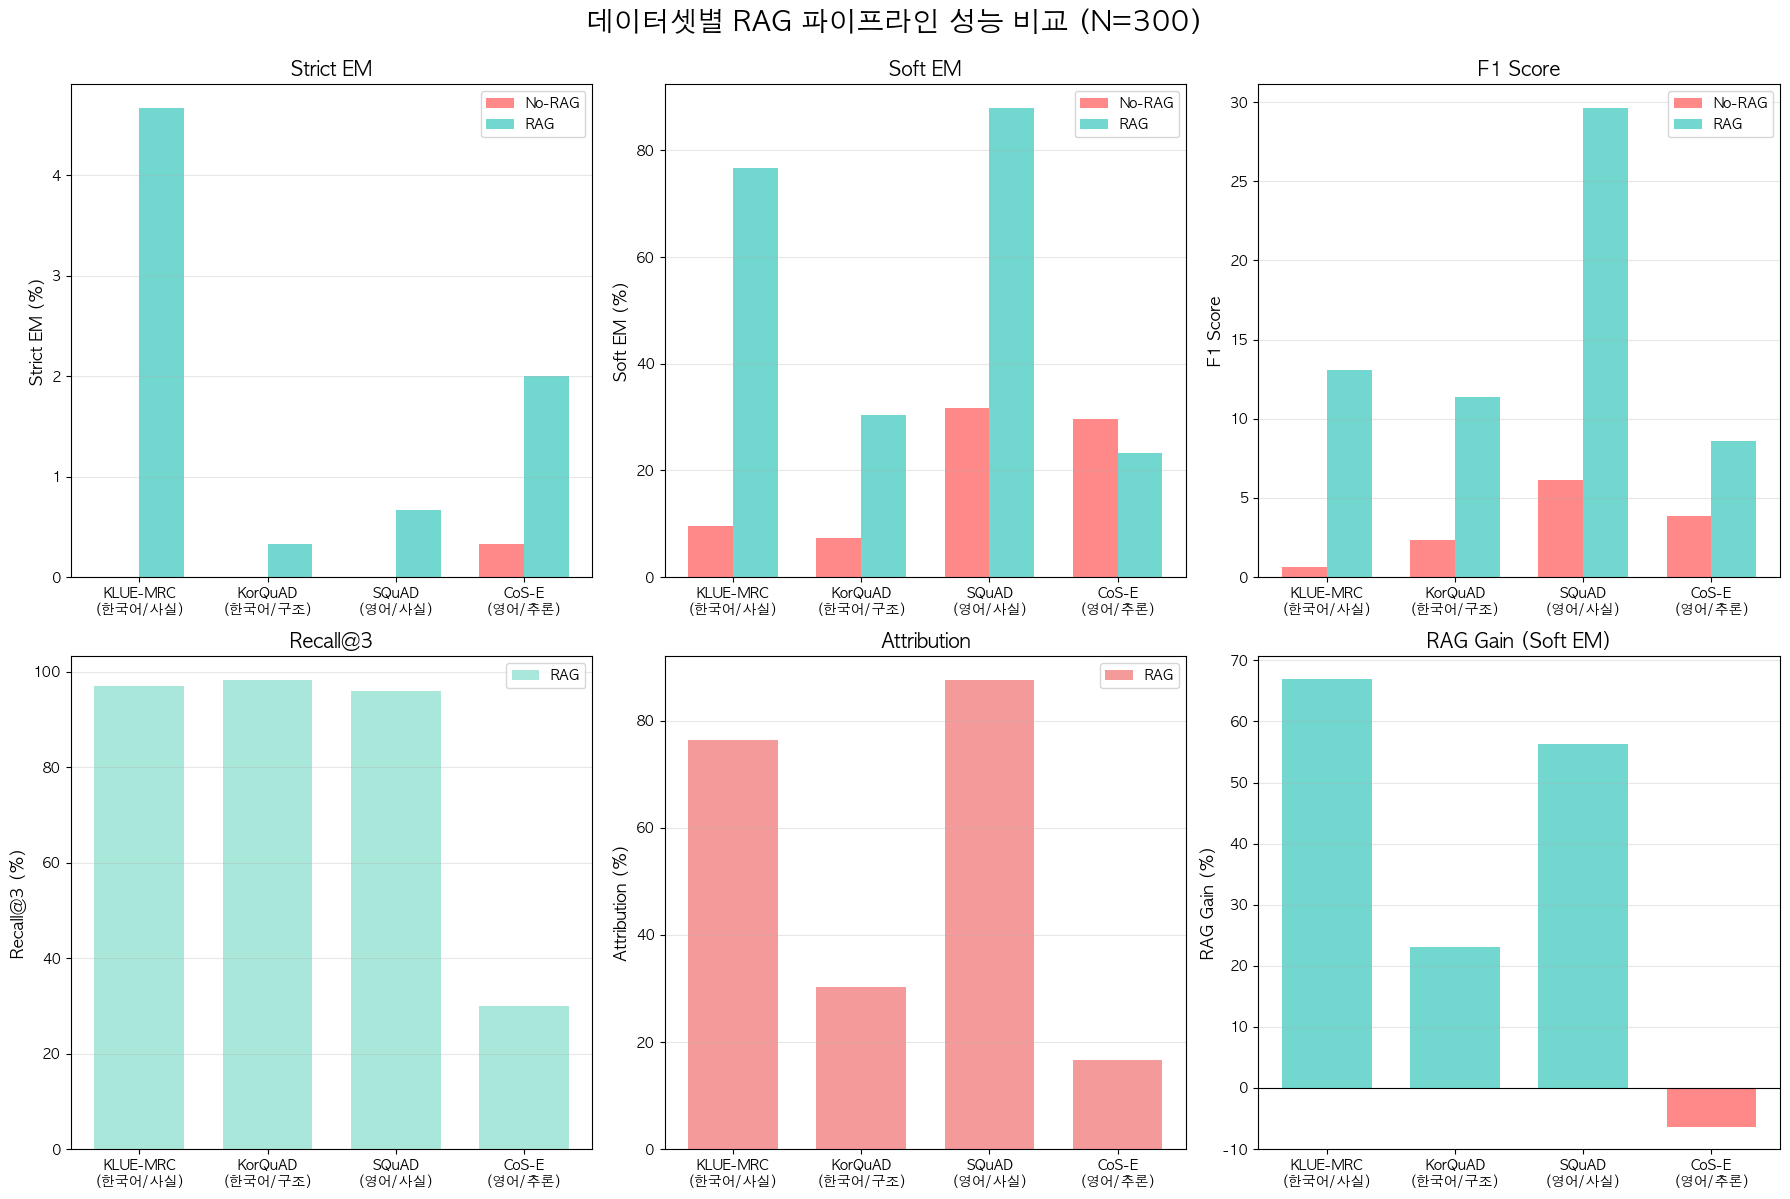

In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터셋 정보
dataset_info = {
    "KLUE-MRC": "KLUE-MRC\n(한국어/사실)",
    "KorQuAD": "KorQuAD\n(한국어/구조)",
    "SQuAD": "SQuAD\n(영어/사실)",
    "CoS-E": "CoS-E\n(영어/추론)"
}

# JSON 파일 로드
with open('reports/evaluation_summary.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 데이터 준비
datasets = []
no_rag_strict_em, no_rag_soft_em, no_rag_f1 = [], [], []
rag_strict_em, rag_soft_em, rag_f1 = [], [], []
recall, attribution = [], []

for item in data:
    dataset = item['dataset']
    metrics = item['metrics']
    datasets.append(dataset_info.get(dataset, dataset))
    no_rag_strict_em.append(metrics['No_RAG_Strict_EM'])
    no_rag_soft_em.append(metrics['No_RAG_Soft_EM'])
    no_rag_f1.append(metrics['No_RAG_F1'])
    rag_strict_em.append(metrics['RAG_Strict_EM'])
    rag_soft_em.append(metrics['RAG_Soft_EM'])
    rag_f1.append(metrics['RAG_F1'])
    recall.append(metrics['Recall'])
    attribution.append(metrics['Attribution'])

x = np.arange(len(datasets))
width = 0.35


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('데이터셋별 RAG 파이프라인 성능 비교 (N=300)', fontsize=20, fontweight='bold', y=0.995)

# 1. Strict EM
ax1 = axes[0, 0]
ax1.bar(x - width/2, no_rag_strict_em, width, label='No-RAG', color='#FF6B6B', alpha=0.8)
ax1.bar(x + width/2, rag_strict_em, width, label='RAG', color='#4ECDC4', alpha=0.8)
ax1.set_ylabel('Strict EM (%)', fontsize=12, fontweight='bold')
ax1.set_title('Strict EM', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets, fontsize=10)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Soft EM
ax2 = axes[0, 1]
ax2.bar(x - width/2, no_rag_soft_em, width, label='No-RAG', color='#FF6B6B', alpha=0.8)
ax2.bar(x + width/2, rag_soft_em, width, label='RAG', color='#4ECDC4', alpha=0.8)
ax2.set_ylabel('Soft EM (%)', fontsize=12, fontweight='bold')
ax2.set_title('Soft EM', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets, fontsize=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. F1 Score
ax3 = axes[0, 2]
ax3.bar(x - width/2, no_rag_f1, width, label='No-RAG', color='#FF6B6B', alpha=0.8)
ax3.bar(x + width/2, rag_f1, width, label='RAG', color='#4ECDC4', alpha=0.8)
ax3.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax3.set_title('F1 Score', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets, fontsize=10)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Recall@3
ax4 = axes[1, 0]
ax4.bar(x, recall, width*2, label='RAG', color='#95E1D3', alpha=0.8)
ax4.set_ylabel('Recall@3 (%)', fontsize=12, fontweight='bold')
ax4.set_title('Recall@3', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(datasets, fontsize=10)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Attribution
ax5 = axes[1, 1]
ax5.bar(x, attribution, width*2, label='RAG', color='#F38181', alpha=0.8)
ax5.set_ylabel('Attribution (%)', fontsize=12, fontweight='bold')
ax5.set_title('Attribution', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(datasets, fontsize=10)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. RAG Gain
ax6 = axes[1, 2]
rag_gain = [rag_soft_em[i] - no_rag_soft_em[i] for i in range(len(datasets))]
colors = ['#4ECDC4' if gain > 0 else '#FF6B6B' for gain in rag_gain]
ax6.bar(x, rag_gain, width*2, color=colors, alpha=0.8)
ax6.set_ylabel('RAG Gain (%)', fontsize=12, fontweight='bold')
ax6.set_title('RAG Gain (Soft EM)', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(datasets, fontsize=10)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('reports/evaluation_bar_charts.png', dpi=300, bbox_inches='tight', facecolor='white')

#### **실험 결과 분석**

**1\. 평가 지표의 유효성 검증**

- Strict EM의 한계:  
모든 데이터셋에서 Strict EM은 0~4% 내외의 매우 낮은 수치를 기록하였다. 이는 gpt-4o-mini가 단답형 지시에도 불구하고 자연어 문장 형태로 답변을 생성하는 경향이 강하기 때문으로 풀이된다. 따라서 본 연구에서는 Soft EM과 F1 Score가 생성형 RAG의 실제 독해 능력을 나타내는 유효한 지표임을 확인하였다.

**2\. 사실 기반 데이터셋(KLUE-MRC, SQuAD)의 RAG 적합성**

- 높은 검색 성능:  
뉴스 및 위키백과를 기반으로 하는 KLUE-MRC와 SQuAD는 각각 97.00%와 96.00%라는 상대적으로 높은 Recall@3 값을 기록하였다.  
이는 질문의 키워드가 본문에 명시적으로 등장하는 특성으로 인해 BM25 검색기가 최적의 성능을 발휘된 것으로 보인다.  
이에 따라 Soft EM 또한 각각 76.67%, 88.00%로 매우 높게 나타났으며,   
Attribution% 또한 Soft EM과 거의 일치하는 수치를 보여 모델이 검색된 문서를 충실히 근거로 활용했음을 나타낸다.

**3\. 구조적 정보 소실에 따른 정답 추출 실패 (KorQuAD)**

- 높은 Recall 대비 낮은 EM:  
KorQuAD는 4개 데이터셋 중 가장 높은 검색 성공률(Recall 98.33%)을 보였으나, 최종 정답률(Soft EM)은 30.33%에 그치는 양상을 보였다.

- 원인 분석:  
검색 단계에서는 정답이 포함된 문서를 잘 찾아왔으나(높은 Recall), 생성 단계에서 정답을 추출하는 데 실패했다.  
이는 KorQuAD 데이터가 본래 표(Table)나 리스트 등 HTML 구조에 정답이 포함된 경우가 많은데,  
텍스트 전처리 과정에서 이러한 구조적 정보가 소실되어 LLM이 문맥을 정확히 파악하지 못한 결과로 해석된다.

**4\. 상식 추론 데이터셋(CoS-E)의 실패와 역효과**

- 검색 실패(Retrieval Failure):  
CoS-E의 Recall은 30.00%로, 타 데이터셋 대비 현저히 낮았다.  
상식 문제는 질문과 설명(문서) 간의 단어 일치도가 낮아 키워드 기반 검색(BM25)의 한계가 드러난 것으로 보인다.

- Negative RAG Gain:  
RAG를 적용했을 때(23.33%)가 적용하지 않았을 때(29.67%)보다 오히려 성능이 하락했다.  
이는 부정확한 문서가 검색되어 모델의 판단을 흐리게 만드는 방해 효과가 발생했음을 나타낸다.

### **4.3 검색 효용성(RAG Gain) 및 응답 지연(Latency) 분석**

외부 지식 검색이 실제 성능 향상에 기여한 정도를 나타내는 RAG Gain과, 시스템의 실시간성을 저해하는 요소인 응답 지연(Latency)을 분석하였다.

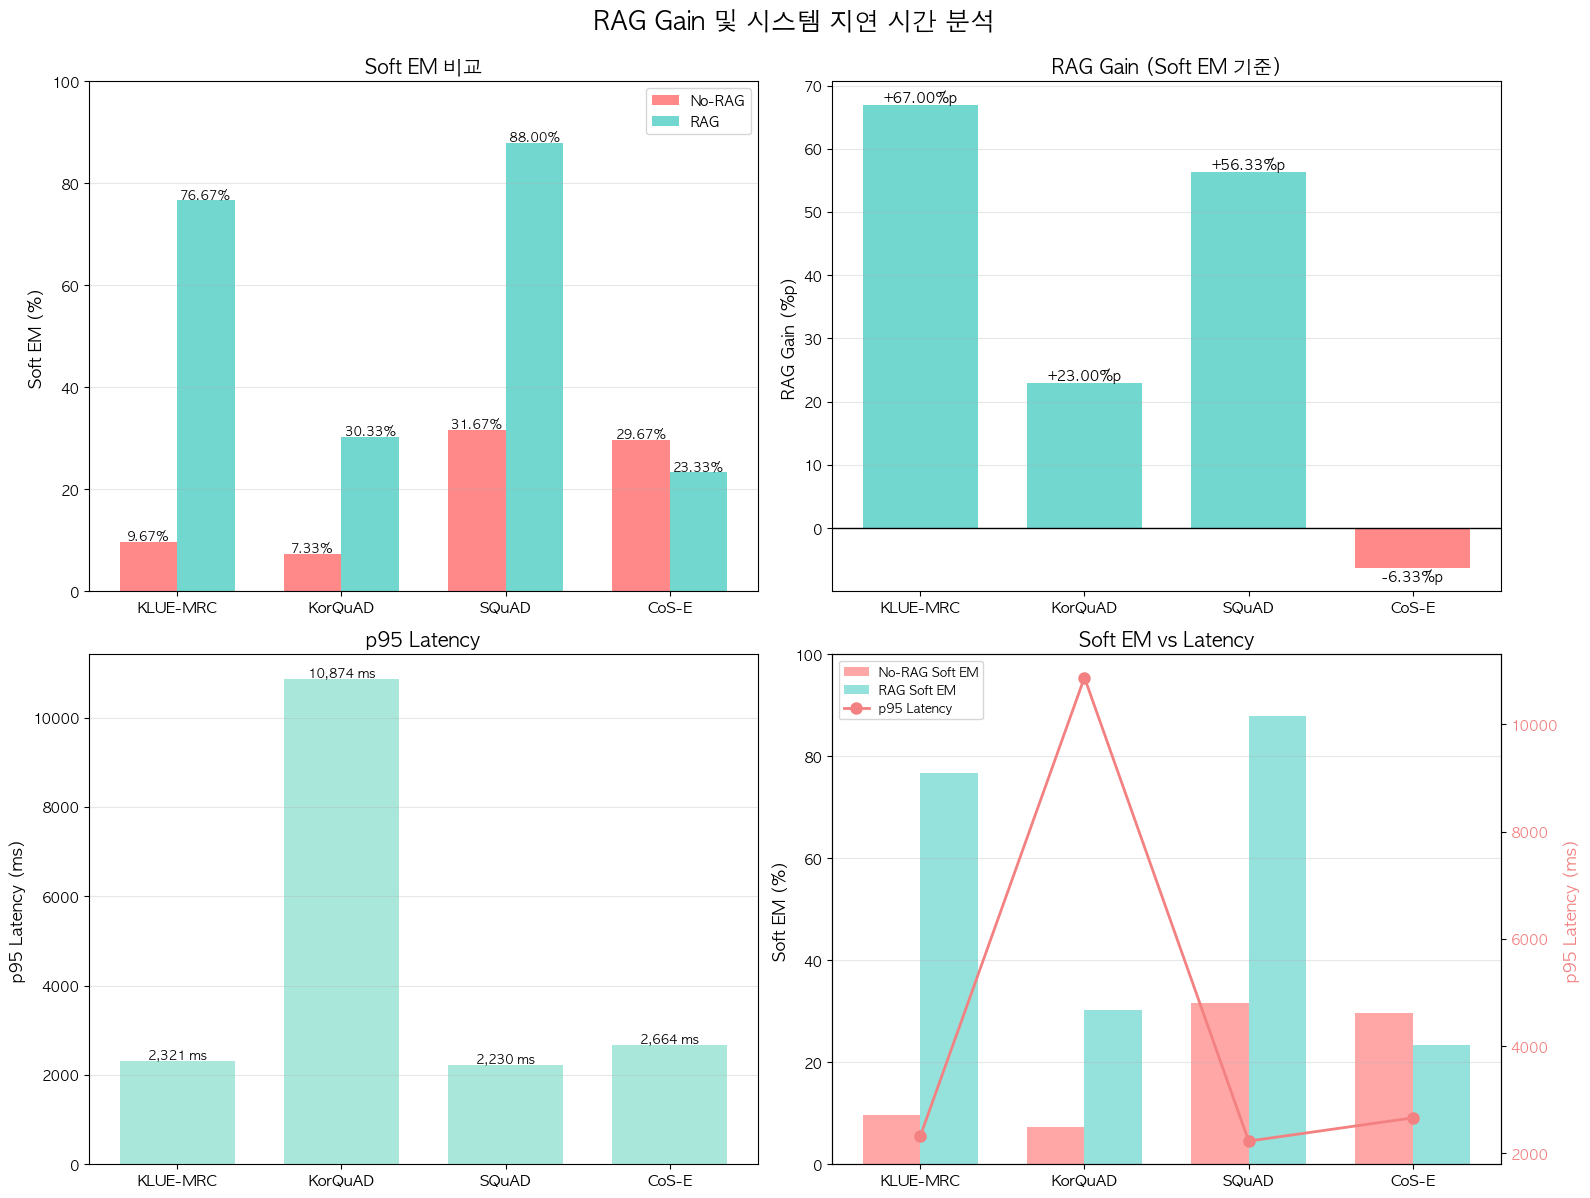

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터
datasets = ['KLUE-MRC', 'KorQuAD', 'SQuAD', 'CoS-E']
no_rag_soft_em = [9.67, 7.33, 31.67, 29.67]
rag_soft_em = [76.67, 30.33, 88.00, 23.33]
rag_gain = [67.00, 23.00, 56.33, -6.33]
p95_latency = [2320.98, 10874.11, 2229.92, 2663.58]

x = np.arange(len(datasets))
width = 0.35

# 4개의 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RAG Gain 및 시스템 지연 시간 분석', fontsize=18, fontweight='bold', y=0.995)

# 1. Soft EM 비교 (No-RAG vs RAG)
ax1 = axes[0, 0]
bars1 = ax1.bar(x - width/2, no_rag_soft_em, width, label='No-RAG', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x + width/2, rag_soft_em, width, label='RAG', color='#4ECDC4', alpha=0.8)
ax1.set_ylabel('Soft EM (%)', fontsize=12, fontweight='bold')
ax1.set_title('Soft EM 비교', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets, fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)
# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# 2. RAG Gain
ax2 = axes[0, 1]
colors = ['#4ECDC4' if gain > 0 else '#FF6B6B' for gain in rag_gain]
bars3 = ax2.bar(x, rag_gain, width*2, color=colors, alpha=0.8)
ax2.set_ylabel('RAG Gain (%p)', fontsize=12, fontweight='bold')
ax2.set_title('RAG Gain (Soft EM 기준)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets, fontsize=11)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)
# 값 표시
for i, (bar, gain) in enumerate(zip(bars3, rag_gain)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{gain:+.2f}%p', ha='center', va='bottom' if gain > 0 else 'top', fontsize=10, fontweight='bold')

# 3. p95 Latency
ax3 = axes[1, 0]
bars4 = ax3.bar(x, p95_latency, width*2, color='#95E1D3', alpha=0.8)
ax3.set_ylabel('p95 Latency (ms)', fontsize=12, fontweight='bold')
ax3.set_title('p95 Latency', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets, fontsize=11)
ax3.grid(axis='y', alpha=0.3)
# 값 표시 (천 단위 구분)
for bar, latency in zip(bars4, p95_latency):
    height = bar.get_height()
    formatted = f'{latency:,.0f} ms'
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            formatted, ha='center', va='bottom', fontsize=9)

# 4. 종합 비교 (Soft EM + Latency)
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

# Soft EM (막대그래프)
bars5 = ax4.bar(x - width/2, no_rag_soft_em, width, label='No-RAG Soft EM', color='#FF6B6B', alpha=0.6)
bars6 = ax4.bar(x + width/2, rag_soft_em, width, label='RAG Soft EM', color='#4ECDC4', alpha=0.6)
ax4.set_ylabel('Soft EM (%)', fontsize=12, fontweight='bold', color='black')
ax4.set_ylim(0, 100)

# Latency (선 그래프)
line = ax4_twin.plot(x, p95_latency, 'o-', color='#F38181', linewidth=2, markersize=8, label='p95 Latency')
ax4_twin.set_ylabel('p95 Latency (ms)', fontsize=12, fontweight='bold', color='#F38181')
ax4_twin.tick_params(axis='y', labelcolor='#F38181')

ax4.set_title('Soft EM vs Latency', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(datasets, fontsize=11)
ax4.grid(axis='y', alpha=0.3)

# 범례 통합
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('reports/performance_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')



#### **실험 결과 분석**

**1\. 지식 유형에 따른 검색 효용성의 양극화**

- 사실(Fact) 기반 데이터의 성능 향상:  
'RAG Gain' 그래프에서 확인할 수 있듯이, KLUE-MRC(+67.00%p)와 SQuAD(+56.33%p)는 높은 성능 향상을 기록했다.  
특히 KLUE-MRC의 경우, 배경지식만으로는 정답률이 9.67%에 불과했으나 RAG 도입 후 76.67%로 상승했다.  
이는 뉴스나 백과사전의 구체적 사실을 다루는 질문의 경우, BM25 기반의 검색 시스템이 정답 도출에 있어 필수적임을 나타낸다.

- 상식 추론(Commonsense) 데이터의 RAG 역효과:  
반면, CoS-E는 4개 데이터셋 중 유일하게 RAG 적용 시 성능이 하락(-6.33%p)하여 0점 아래로 떨어지는 막대 그래프를 보였다.  
이는 낮은 검색 정확도(Recall 30%)로 인해 관련 없는 문서가 컨텍스트로 주입되면서, 모델의 기존 상식 추론마저 방해하는 현상이 발생했음을 나타낸다.


**2\. 구조적 복잡성과 응답 지연의 상관관계**

- KorQuAD의 이상 지연(Outlier):  
'p95 Latency' 그래프에서 KorQuAD는 타 데이터셋 대비 약 5배에 달하는 10,874ms (약 10.9초)의 지연 시간을 기록하는 이상치를 보였다.  
KLUE-MRC(2,321ms), SQuAD(2,230ms), CoS-E(2,664ms)가 모두 2초 대의 균일한 처리 속도를 보인 것과 대조적이다.  
이는 KorQuAD의 문서가 한국어 위키백과 특유의 긴 호흡과 복잡한 구조를 가지고 있어,   
gpt-4o-mini가 입력 토큰을 인코딩하고 답변을 생성하는 과정에서 과도한 연산 비용이 발생했음을 나타낸다.

- 효율성 vs 성능 tradeoff:  
'Soft EM vs Latency' 그래프에서 KorQuAD는 "가장 느린 속도(High Latency)"를 보였음에도 불구하고,  
"낮은 성능 향상폭(Low Performance)"을 보이며 현재의 단일 파이프라인 구성에서 가장 비효율적인 데이터셋임이 확인되었다.

### **4.4 강건성(Robustness) 테스트 결과**

질문의 의미는 유지하되, 어휘와 표현을 변경한 패러프레이즈 질문(Paraphrased Question)에 대해   
단일 RAG 파이프라인이 얼마나 안정적인 성능을 유지하는지(ΔEM) 평가한 결과이다.

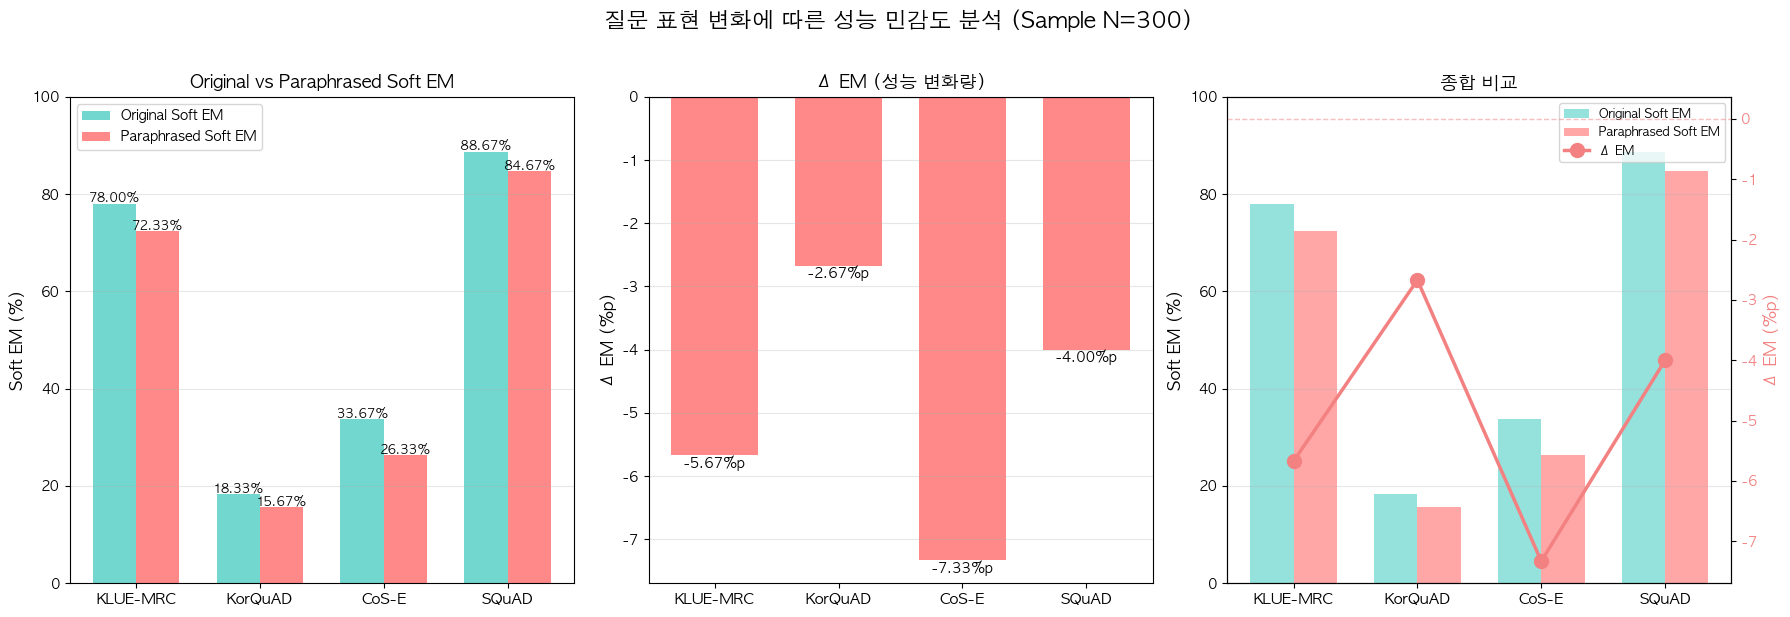

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# JSON 파일 로드
with open('reports/robustness_summary.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 데이터 준비
datasets = []
original_em = []
paraphrased_em = []
delta_em = []

for item in data:
    datasets.append(item['dataset'])
    original_em.append(item['metrics']['Original_EM'])
    paraphrased_em.append(item['metrics']['Paraphrased_EM'])
    delta_em.append(item['metrics']['Delta_EM'])

x = np.arange(len(datasets))
width = 0.35

# 3개의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(' 질문 표현 변화에 따른 성능 민감도 분석 (Sample N=300)', 
             fontsize=16, fontweight='bold', y=1.02)

# 1. Original vs Paraphrased Soft EM 비교
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, original_em, width, label='Original Soft EM', color='#4ECDC4', alpha=0.8)
bars2 = ax1.bar(x + width/2, paraphrased_em, width, label='Paraphrased Soft EM', color='#FF6B6B', alpha=0.8)
ax1.set_ylabel('Soft EM (%)', fontsize=12, fontweight='bold')
ax1.set_title('Original vs Paraphrased Soft EM', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets, fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)
# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# 2. Δ EM (성능 변화량)
ax2 = axes[1]
colors = ['#FF6B6B' if delta < 0 else '#4ECDC4' for delta in delta_em]
bars3 = ax2.bar(x, delta_em, width*2, color=colors, alpha=0.8)
ax2.set_ylabel('Δ EM (%p)', fontsize=12, fontweight='bold')
ax2.set_title('Δ EM (성능 변화량)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets, fontsize=11)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax2.grid(axis='y', alpha=0.3)
# 값 표시
for bar, delta in zip(bars3, delta_em):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{delta:+.2f}%p', ha='center', va='bottom' if delta > 0 else 'top', 
            fontsize=10, fontweight='bold')

# 3. 종합 비교 (Original, Paraphrased, Δ EM)
ax3 = axes[2]
ax3_twin = ax3.twinx()

# Original vs Paraphrased (막대그래프)
bars4 = ax3.bar(x - width/2, original_em, width, label='Original Soft EM', color='#4ECDC4', alpha=0.6)
bars5 = ax3.bar(x + width/2, paraphrased_em, width, label='Paraphrased Soft EM', color='#FF6B6B', alpha=0.6)
ax3.set_ylabel('Soft EM (%)', fontsize=12, fontweight='bold', color='black')
ax3.set_ylim(0, 100)

# Δ EM (선 그래프)
line = ax3_twin.plot(x, delta_em, 'o-', color='#F38181', linewidth=2.5, markersize=10, label='Δ EM')
ax3_twin.set_ylabel('Δ EM (%p)', fontsize=12, fontweight='bold', color='#F38181')
ax3_twin.tick_params(axis='y', labelcolor='#F38181')
ax3_twin.axhline(y=0, color='#F38181', linestyle='--', linewidth=1, alpha=0.5)

ax3.set_title('종합 비교', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets, fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# 범례 통합
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('reports/robustness_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')

#### **실험 결과 분석**

**1\. 보편적인 강건성 취약점 확인**

- 모든 데이터셋에서 질문의 표현이 바뀌었을 때 성능이 하락(ΔEM < 0)하는 경향이 일관되게 나타났다.   
이는 BM25 기반의 단일 RAG 파이프라인이 어휘적 변화에 구조적으로 취약함을 의미한다.

**2\. 데이터셋별 강건성 차이**

- CoS-E의 최대 낙폭(-7.33%p):  
상식 추론 문제는 질문의 뉘앙스나 특정 단어가 문맥을 결정하는 경우가 많아, 패러프레이징에 가장 민감하게 반응하였다.

- 키워드 변화에 따른 성능 저하:  
상세 분석 결과, 원본 질문의 핵심 키워드가 동의어(예: 통치권자 → 지도자)로 교체된 경우   
패러프레이즈 질문의 EM 점수가 크게 하락하는 사례가 확인되었다.  
예를 들어, KLUE-MRC 데이터셋에서 "음식물 자원화 시설을 들인 단체의 통치권자 이름은?"이라는 원본 질문은 정답을 맞췄으나(EM=1.0),  
"음식물 자원화 시설을 설치한 단체의 지도자의 이름은 무엇인가요?"로 패러프레이즈된 질문은 오답을 생성했다(EM=0.0).  
이는 BM25 기반 키워드 매칭 검색이 동의어 변화에 취약할 수 있음을 시사하며, 의미 기반 검색(Dense Retrieval)의 필요성을 보여준다.

In [ ]:
# 키워드 변화에 따른 성능 저하 사례
{
    "original_q": "음식물 자원화 시설을 들인 단체의 통치권자 이름은?",
    "paraphrased_q": "음식물 자원화 시설을 설치한 단체의 지도자의 이름은 무엇인가요?",
    "original_answer": "음식물 자원화 시설을 들인 단체의 통치권자는 울산시장 박맹우입니다.",
    "paraphrased_answer": "음식물 자원화 시설을 설치한 단체의 지도자의 이름은 류성렬 유성 회장입니다.",
    "gold_answers": [
      "박맹우"
    ],
    "em_orig": 1.0,
    "em_para": 0.0,
    "delta_em": -1.0
},

## **5. 상세 분석**

### **5.1 사실 검색과 상식 추론의 근본적 차이** 

실험 결과, 가장 두드러진 특징은 **사실 기반 질문**에서는 RAG가 강력한 성능을 발휘한 반면,  
**상식 추론 질문**에서는 오히려 역효과를 냈다는 점이다. 이는 데이터셋이 요구하는 지식의 성격 차이로 인해 발생한다.

- 사실 기반 데이터(KLUE-MRC, SQuAD)의 성공 요인:  
해당 데이터셋들은 뉴스나 백과사전에서 특정 정보(인물, 날짜, 장소 등)를 찾는 것을 목적으로 한다.   
질문에 포함된 핵심 단어가 본문에도 그대로 등장하는 경우가 많아, 키워드 매칭 방식인 BM25 검색기가 정답 문서를 정확하게 찾아낼 수 있었다.   
결과적으로 외부 문서를 참고하는 것이 모델의 부족한 지식을 완벽하게 보완하여 높은 성능 향상으로 이어졌다.

- 상식 추론 데이터(CoS-E)의 한계와 정보 간섭:  
반면, 상식 문제는 질문과 정답 사이에 직접적인 단어 중복이 거의 없다.  
예를 들어 CoS-E 데이터셋의 "He has lactose intolerant, but was eating dinner made of cheese, what followed for him?"이라는  
질문의 정답은 "indigestion"이고, 그 근거 설명은 "Indigestion (for Kids) - KidsHealth"이나, 질문과 설명 사이에 겹치는 핵심 단어가 없어  
BM25는 관련 문서를 찾지 못했다.  
또한 엉뚱한 문서가 검색되어 프롬프트에 들어가면서, 모델이 원래 가지고 있던 올바른 상식조차 헷갈리게 만드는 '정보 간섭(Distraction)' 현상이 발생하였다.  
예를 들어 "Where would you get some maps that you own?"(정답: "cabinet") 질문의 경우, No-RAG는 정답을 포함한 답변을 생성했으나,  
RAG는 "fruit stand..."와 같은 엉뚱한 문서가 검색되어 "Based on the documents provided, there is no specific mention..."이라는 오답을 생성했다.  
이는 단순 키워드 검색만으로는 상식 추론형 RAG를 구현하기 어려움을 시사한다.

In [ ]:
# 단어 미중복으로 인한 사례
{
    "id": "3b4dcfcab4726496bdbe9535cc669082",
    "question": "He has lactose intolerant, but was eating dinner made of cheese, what followed for him?",
    "recall_success": false,
    "no_rag_answer": "If he is lactose intolerant and ate dinner made of cheese, he likely experienced digestive discomfort. This could include symptoms such as bloating, gas, stomach cramps, diarrhea, or nausea. The severity of these symptoms can vary depending on the amount of lactose consumed and his individual tolerance level. It's advisable for individuals with lactose intolerance to avoid or limit dairy products to prevent such reactions.",
    "rag_answer": "Based on the provided documents, there is no information related to lactose intolerance or the consequences of eating cheese for someone who is lactose intolerant. Therefore, I cannot provide an answer to the question.",
    "gold_answers": [
      "indigestion"
    ],
    "retrieved_top1": "After he got hired he hoped for success at his new...",
    "latency": 1464.4899368286133
},


# 정보 간섭 사례
{
    "id": "4536489e5d8e02aadc3fcc7a55effe20",
    "question": "Where would you get some maps that you own?",
    "recall_success": false,
    "no_rag_answer": "You can find maps that you own in several places, depending on the type of maps and how you acquired them:\n\n1. **Physical Maps**: If you have physical copies of maps, they might be stored in a designated area like a filing cabinet, a drawer, or a specific folder in your home or office.\n\n2. **Digital Maps**: If you have digital maps, they could be saved on your computer, tablet, or smartphone. Check your files, downloads, or any specific mapping applications you use.\n\n3. **Mapping Apps**: If you use mapping services like Google Maps, Apple Maps, or specialized apps (like hiking or travel apps), your saved locations or maps may be stored within those applications.\n\n4. **Cloud Storage**: If you use cloud services (like Google Drive, Dropbox, or OneDrive), your maps might be stored there if you uploaded them.\n\n5. **Email or Messaging Apps**: If someone shared maps with you via email or messaging apps, you might find them in your inbox or chat history.\n\n6. **Library or Archive**: If you own historical or specialized maps, they might be stored in a library or archive if you donated or loaned them.\n\nIf you're looking for a specific map, try to remember where you last used or accessed it, as that might help you locate it more easily.",
    "rag_answer": "Based on the documents provided, there is no specific mention of where to get maps that you own. Therefore, I cannot provide a definitive answer based on the given information.",
    "gold_answers": [
      "cabinet"
    ],
    "retrieved_top1": "fruit standIf you really wanted a grape, where wou...",
    "latency": 1193.6500072479248
},

### **5.2 구조적 정보 소실로 인한 정답 추출 실패**

KorQuAD 데이터셋에서 관찰된 "문서는 잘 찾았으나(Recall 98%), 정답은 못 맞히는(EM 30%)" 현상은 텍스트 전처리 과정의 한계를 보여준다.

- HTML 구조의 중요성 간과:  
KorQuAD는 웹 문서의 표나 리스트 구조 속에 정답이 존재하는 경우가 많다.  
그러나 본 연구의 단일 파이프라인은 이러한 HTML 태그를 모두 제거하고 줄글(Plain Text)로 변환하여 입력했다.


- 문맥 파악의 어려움:  
검색 단계에서는 키워드가 포함된 문단을 잘 찾아왔지만, 생성 단계에서 모델은 표의 행/열 구조가 사라진 텍스트를 보고 정답이 무엇인지 파악하지 못했다.  
이는 구조화된 문서를 RAG에 활용할 때는 텍스트만 추출할 것이 아니라, 구조 정보를 보존하는 별도의 처리 전략이 필수적임을 의미한다.

### **5.3 한국어 처리의 비효율성과 응답 지연**

시스템 응답 속도(Latency) 분석 결과, 한국어 데이터셋(KorQuAD)이 영어 데이터셋보다 처리 시간이 월등히 길게 측정되었다.

- 토큰화 효율성 차이:  
실험에 사용된 gpt-4o-mini 모델은 영어 중심의 토크나이저를 사용한다.   
영어는 단어 단위로 효율적인 처리가 가능한 반면, 한국어는 교착어 특성상 조사가 붙어 있어 더 많은 수의 토큰으로 잘게 쪼개진다.

- 연산 비용 증가:  
같은 의미를 전달하더라도 한국어는 영어보다 처리해야 할 토큰의 길이가 길어지며, 이는 곧 연산량 증가와 응답 지연으로 이어졌다.   
따라서 한국어 RAG 서비스를 구축하는 경우 한국어 처리 효율이 높은 모델을 선정하거나,  
응답 속도를 개선하기 위한 최적화 작업이 중요하게 고려되어야 한다.

### **5.4 어휘 변화에 대한 취약성 (강건성 평가)**

질문의 표현을 조금만 바꾸어도(패러프레이징) 성능이 하락하는 현상은 키워드 기반 검색(BM25)의 근본적 한계를 드러낸다.

- 의미가 아닌 형태에 의존:   
"통치권자"를 "지도자"로 바꾸었을 때 답변을 못 하는 사례처럼, 현재 시스템은 단어의 의미를 이해하는 것이 아니라 글자 형태가 같은지만 확인한다.

- 시사점:  
사용자가 항상 문서에 있는 정확한 용어로 질문하지 않는다는 점을 고려할 때,  
실제 서비스에서는 동의어나 유사 표현까지 이해할 수 있는 의미 기반 검색이 도입되어야만 시스템의 안정성을 높일 수 있을 것이다.

## **6. 결론**

### **6.1 연구 요약 및 주요 발견**
실험 결과, RAG 시스템은 모든 데이터셋에 대해서 무조건적인 성능 향상을 보장하지 않으며,  
데이터셋의 '제작 목적'과 '구조'에 따라 성능 향상 효과가 극적으로 달라짐을 확인하였다.

- 지식 유형의 결정적 영향:   
뉴스나 백과사전 기반의 사실 검색(Factoid) 데이터셋(KLUE-MRC, SQuAD)에서는 키워드 매칭(BM25)이 매우 효과적으로 작동하여 비약적인 성능 향상(High RAG Gain)을 이끌어냈다. 반면, 상식 추론(Commonsense) 데이터셋(CoS-E)에서는 질문과 근거 사이의 어휘적 불일치로 인해 검색이 실패하거나, 잘못된 정보가 주입되어 성능이 오히려 하락하는 역효과가 발생하였다.

- 구조적 정보의 중요성:  
구조적 데이터셋(KorQuAD) 실험을 통해, 표나 리스트와 같은 HTML 구조 정보를 평문으로 단순 변환할 경우, 검색에는 성공하더라도 모델이 문맥을 이해하지 못해 정답을 맞히지 못하는 현상을 발견하였다.

- 단일 파이프라인의 한계:  
강건성 테스트를 통해 키워드 기반의 단일 파이프라인이 동의어 치환과 같은 단순한 어휘 변화에도 취약함을 확인하였으며, 한국어 처리 시 토큰화 비효율성으로 인한 응답 지연 문제 또한 나타났다.

### **6.2 연구의 시사점 및 제언**

본 연구의 결과는 향후 RAG 시스템 구축 시 다음과 같은 전략적 고려가 필요함을 시사한다.

- 검색 전략의 이원화:  
 명확한 고유명사나 사실을 묻는 질문에는 키워드 검색(BM25)이 여전히 강력하고 효율적이다.  
 그러나 상식 추론이나 의미적 모호성이 높은 질문에는 문맥을 파악할 수 있는 임베딩 기반의 Dense Retrieval이나  
 하이브리드 검색(Hybrid Search) 도입이 필수적이다.

- 데이터 맞춤형 전처리:   
구조화된 문서를 다룰 때는 텍스트만 추출하는 방식을 지양하고, 마크다운(Markdown) 변환이나 구조 정보를 보존하는 인덱싱 기법을 적용하여   
LLM이 구조적 문맥을 이해할 수 있도록 지원해야 한다.

- 언어 특성을 고려한 최적화:   
한국어 RAG 서비스의 실시간성을 확보하기 위해서는 영어 중심의 모델을 그대로 사용하기보다, 한국어 토큰 처리 효율이 최적화된 모델을 선정하거나   
한국어 특화 토크나이저를 적용하는 것이 시스템 비용 절감과 응답 속도 개선 측면에서 필요하다.

## **참고 문헌 (References)**
- KLUE: Korean Language Understanding Evaluation (S. Park et al., 2021).  
https://arxiv.org/pdf/2105.09680

- KorQuAD 2.0: Korean QA Dataset for Web Document Machine Comprehension (Y. Kim et al., 2020).  
https://jok.kiise.or.kr/digital-library/100414

- SQuAD: 100,000+ Questions for Machine Comprehension of Text (P. Rajpurkar et al., 2016).

- CoS-E: Explain Yourself! Leveraging Language Models for Commonsense Reasoning (N. F. Rajani et al., 2019)
https://arxiv.org/pdf/1906.02361
